<h1><center>Сегментация изображений</center></h1>

Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

Обучить модель на выбор из segmentation_models_pytorch

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F
import torch.nn as nn

In [3]:
import segmentation_models_pytorch as smp

In [4]:
import time

In [5]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        self.data_info = data_info
        self.image_arr = self.data_info.iloc[:,0]
        self.mask_arr = self.data_info.iloc[:,1]
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        img = torch.as_tensor(img)/255
        img = img.unsqueeze(0).permute(0,3,1,2)
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        lab = np.asarray(plt.imread(self.mask_arr[index])).astype('float')[:,:,0]*255
        lab = torch.as_tensor(lab).unsqueeze(0)
        lab = lab.unsqueeze(0)
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

python/PyTorch/hw/lips_dataset/set-lipstick-original/mask  
python/PyTorch/hw/lips_dataset/set-lipstick-original/720p

In [6]:
np.array(plt.imread('lips_dataset/set-lipstick-original/mask/mask00000017.png')).shape

(720, 1280, 3)

In [7]:
np.array(plt.imread('lips_dataset/set-lipstick-original/mask/mask00000017.png')).min()

0.0

In [8]:
np.array(np.array(plt.imread('lips_dataset/set-lipstick-original/720p/image00000025.jpg'))/255).max()

1.0

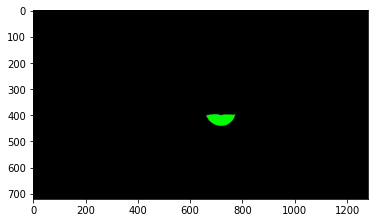

In [9]:
mask = plt.imread('lips_dataset/set-lipstick-original/mask/mask00000017.png')
plt.imshow(mask)
plt.show()

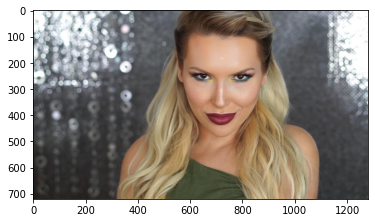

In [10]:
img = plt.imread('lips_dataset/set-lipstick-original/720p/image00000025.jpg')
plt.imshow(img)
plt.show()

In [11]:
image_address = []
mask_address = []
for root, dirs, files in os.walk('lips_dataset'):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            image_address.append(f)
        elif 'mask' in f:
            mask_address.append(f)
        else:
            break

In [12]:
len(image_address), len(mask_address)

(8382, 8382)

In [13]:
df = pd.DataFrame({'image_source': image_address, 'mask_source': mask_address})
df.sort_values(by='image_source',inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.head(5))

                                        image_source  \
0  lips_dataset\set-lipstick-original\720p\image0...   
1  lips_dataset\set-lipstick-original\720p\image0...   
2  lips_dataset\set-lipstick-original\720p\image0...   
3  lips_dataset\set-lipstick-original\720p\image0...   
4  lips_dataset\set-lipstick-original\720p\image0...   

                                         mask_source  
0  lips_dataset\set-lipstick-original\mask\mask00...  
1  lips_dataset\set-lipstick-original\mask\mask00...  
2  lips_dataset\set-lipstick-original\mask\mask00...  
3  lips_dataset\set-lipstick-original\mask\mask00...  
4  lips_dataset\set-lipstick-original\mask\mask00...  


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df,test_size=0.3)

X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)


train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [15]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=1,shuffle=False)

In [16]:
data = next(iter(train_data_loader))
print(data[0].mean(), data[0].std())

tensor(0.4512) tensor(0.2123)


In [17]:
learning_rate = 0.0001
epochs = 50

## Часть 3. Обучение

In [18]:
def dice_loss(output, target, weights=None, ignore_index=None):
    """
    output : NxCxHxW Variable torch.Size([1, 1, 256, 256])
    target :  NxHxW LongTensor torch.Size([1, 256, 256])
    weights : C FloatTensor
    ignore_index : int index to ignore from loss
    """
    eps = 0.0001

    output = output.float()
 #   encoded_target = output.detach()
 #   encoded_target = output.detach().exp()
    target = target.type(torch.int64)
    target = target.unsqueeze(1)
 #   encoded_target = encoded_target * 0

    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else: # the role of this part of the code un
        pass
        #encoded_target.scatter_(1, target.unsqueeze(1), 1) # target.unsqueeze(1) -> torch.Size([1, 1, 256, 256])

    if weights is None:
        weights = 1

    intersection = target * output
    numerator = 2 * intersection + 1
    denominator = target + output + 1

    if ignore_index is not None:
        denominator[mask] = 0
#    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = weights * (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

Выберем утройство,на котором будем обучать нашу модель.

In [19]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
device

device(type='cpu')

In [21]:
#Umodel = UNet(num_classes=13).to(device)
#optimizer = torch.optim.Adam(Umodel.parameters(), lr=learning_rate)

In [23]:
# создание модели
segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', classes=1, activation='sigmoid').to(device)
optimizer = torch.optim.Adam(segmodel.parameters())

step_losses = []
epoch_losses = []

for epoch in range(20):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
#        inputs = inputs.cuda()
 #       labels = labels.cuda()


        # zero the parameter gradients
        optimizer.zero_grad()
  
        # forward + backward + optimize
        outputs = segmodel(inputs[0])
        loss = dice_loss(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()
  
        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 500 == 0:    # print every 500 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 500 images: {running_loss/500}')
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')

Epoch: 0, batchcount: 500, avg. loss for last 500 images: 1484.691942352295
Epoch: 0, batchcount: 1000, avg. loss for last 500 images: 1684.0208985443114
Epoch: 0, batchcount: 1500, avg. loss for last 500 images: 1882.2101669311523
Epoch: 0, batchcount: 2000, avg. loss for last 500 images: 2073.605023590088
Epoch: 0, batchcount: 2500, avg. loss for last 500 images: 2263.8127182922362


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed